In [1]:
import numpy as np
import scipy.constants as const
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy.integrate import quadrature
import pandas as pd
import config
from scipy import optimize
import pdfplumber
import scraper
from constants import *

In [2]:
userHome = config.userHome()
outdir = userHome + "/projects/cs/data/raw/ext/n2/itikawa/"
pdfHome = userHome + "/projects/cs/ref/angus/"

In [3]:
pdfGilmore = scraper.getPDF(pdfHome + "30_gilmore_j_phys_chem_ref_data_21_1005_1992.pdf")

In [4]:
pi = const.pi
e = const.e
e0= const.epsilon_0

In [5]:
eV_per_J = const.physical_constants["joule-electron volt relationship"][0]
cm_per_m = 100.0

In [6]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [7]:
math.ceil(22/2)

11

In [8]:
mu=1.16294E-26
wavenumber_per_eV = 8065.6

In [9]:
from scipy.integrate import romberg

In [10]:
def f(v, vibConstants):
    #I = quad(fIntegrand,-1/2,v,args=(v, vibConstants), full_output=True, epsabs=1.0E-16, limit=24)
    I = quadrature(fIntegrand, -1/2, v, args=(v, vibConstants), vec_func=False, miniter=24, tol=1E-16)
    #I = romberg(fIntegrand, -1/2, v, args=(v, vibConstants))
    #if v == 10:
        #print("Computing f for v==10")
        #print("=====================")
        #print(I)
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    #I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants), epsabs=1.0E-16, limit=24)
    I = quadrature(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants), vec_func=False, miniter=24, tol=1E-16)
    #I = romberg(gIntegrand, -1/2, v, args=(v, vibConstants, rotConstants))
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [11]:
def r(v, vibConstants, rotConstants):
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [12]:
def Jv(vMaxN2, vMaxN2p, stateN2, stateN2p):

    N2pPES = []
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2p[stateN2p]

    for vp in range(vMaxN2p+1):
        #print(vp)
        rvp=r(vp, vibConstantsN2p[stateN2p], rotConstantsN2p[stateN2p])
        #print(rvp)
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        #print(Tvp)
        N2pPES.insert(0, [rvp[0], Tvp])
        N2pPES.append([rvp[1], Tvp])
        #print(N2pPES[0])
    
    N2pPES = np.asarray(N2pPES)
    
    #print(N2pPES[:,0])
    #print(N2pPES[:,1])
    
    I_N2pPES = interpolate.interp1d(N2pPES[:,0], N2pPES[:,1], kind='quadratic')

    N2PES = []
    JvArray = np.empty([vMaxN2+1,2])
        
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2[stateN2]
    for v in range(len(JvArray)):
        rv=r(v, vibConstantsN2[stateN2], rotConstantsN2[stateN2])
        Tvv=Tv(v, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        N2PES.insert(0, [rv[0], Tvv])
        N2PES.append([rv[1], Tvv])
        JvArray[v] = I_N2pPES(rv)-Tvv

    N2PES = np.asarray(N2PES)
        
    return (N2PES, N2pPES, JvArray)

In [13]:
(N2PES, N2pPES, Jvv) = Jv(15,30,0,0)

/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.261792e-06
  AccuracyWarning)
/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.011461e-05
  AccuracyWarning)
/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.182376e-06
  AccuracyWarning)
/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.747694e-05
  AccuracyWarning)
/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.194541e-05
  AccuracyWarning)
/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-pa

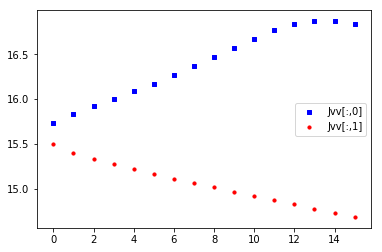

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = list(range(len(Jvv)))
y = Jvv[:,0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='Jvv[:,0]')
y = Jvv[:,1]
ax1.scatter(x,y, s=10, c='r', marker="o", label='Jvv[:,1]')
plt.legend(loc='center right');
plt.show()

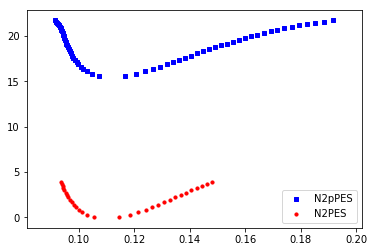

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x,y = N2pPES.T
ax1.scatter(x, y, s=10, c='b', marker="s", label='N2pPES')
x,y = N2PES.T
ax1.scatter(x,y, s=10, c='r', marker="o", label='N2PES')
plt.legend(loc='lower right');
plt.show()

In [16]:
def f_eqn15(x: float):
    "Equation 15 of Kosarim, et al., for all electrons."
    "return (6*(x-1))/(pi*(x+1.5)*(x+9))"
    return (6*(x-1))/(pi*(x+10)*(x+2))

In [17]:
def sigma_ion(f, n: int, E: float, J_v_vp: float, J_v_vpp: float):
    """Compute cross-sections (10^-17 cm^2) of ionization transitions for 
    Tables 2-4 of Kosarim, et al."""
    return (cm_per_m**2 * eV_per_J**2)/(1.0E-17)  * (1./(4.*pi*e0)**2) * \
        ((n*e**4)/2.) * ( f(E/J_v_vp)/(J_v_vp**2) + f(E/J_v_vpp)/(J_v_vpp**2) )

In [18]:
datafiles = [outdir+"ionization_N2+_itikawa2006_15",
             outdir+"ionization_N2+_itikawa2006_16",
             outdir+"ionization_N2+_itikawa2006_17"]
sigma_total=[]

for datafile in datafiles:
    df = pd.read_csv(datafile, sep="\t")   # read .tsv file into memory
    sigma_total.append(df.values[:,[1,2]])  # access the numpy array containing values

sigma_total=np.concatenate((sigma_total[0],
                            sigma_total[1],
                            sigma_total[2]), axis=0)

In [19]:
N2_ionization = 15.581 # best value of the ionization energy of N2

In [20]:
sigma_total_reduced = np.column_stack((sigma_total[:,0]/N2_ionization, 
                                       (N2_ionization**2)/( (cm_per_m**2 * eV_per_J**2)/(1.0E-17)  * (1./(4.*pi*e0)**2) * ((2*e**4)) ) * sigma_total[:,1]))

In [21]:
sigma_total_reduced

array([[1.05898209e+00, 2.72799132e-03],
       [1.09107246e+00, 4.17394380e-03],
       [1.12316283e+00, 5.76624775e-03],
       [1.15525319e+00, 7.55173563e-03],
       [1.18734356e+00, 9.60065615e-03],
       [1.21943393e+00, 1.16495767e-02],
       [1.25152429e+00, 1.34643348e-02],
       [1.28361466e+00, 1.58059583e-02],
       [1.31570503e+00, 1.80305006e-02],
       [1.34779539e+00, 2.01379617e-02],
       [1.37988576e+00, 2.22454228e-02],
       [1.41197612e+00, 2.44699651e-02],
       [1.44406649e+00, 2.66359668e-02],
       [1.47615686e+00, 2.88019684e-02],
       [1.50824722e+00, 3.09094295e-02],
       [1.54033759e+00, 3.30754312e-02],
       [1.57242796e+00, 3.52999735e-02],
       [1.60451832e+00, 3.74659752e-02],
       [1.92542199e+00, 5.43842046e-02],
       [2.24632565e+00, 6.79070801e-02],
       [2.56722932e+00, 8.02006032e-02],
       [3.20903665e+00, 9.36649380e-02],
       [3.52994031e+00, 9.71773732e-02],
       [3.85084398e+00, 1.00689808e-01],
       [4.171747

In [22]:
# Fit the first set
fitfunc = lambda p, x: p[0]*(x-p[1])/(pi*(x+p[2])*(x+p[3])) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [6.0, 1.0, 10.0, 2.0] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(sigma_total_reduced[:,0], sigma_total_reduced[:,1]))

In [23]:
p1

array([ 9.20561178,  1.08494814, 12.72550793,  1.13973716])

In [24]:
success

1

In [25]:
def f_eqn_fit(x: float):
    "Fit total ionization data"
    return (p1[0]*(x-p1[1]))/(pi*(x+p1[2])*(x+p1[3]))

/home/adamson/anaconda3/envs/nepc/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


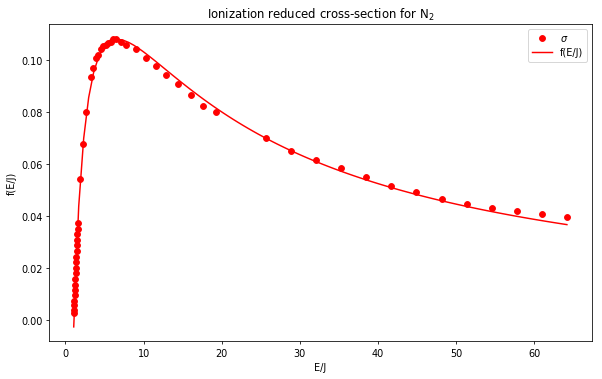

In [26]:
w = 10
h = 6
d = 70
plt.figure(figsize=(w, h), dpi=d)

x=sigma_total_reduced[:,0]
y=sigma_total_reduced[:,1]

x = np.linspace(min(sigma_total_reduced[:,0]), max(sigma_total_reduced[:,0]), 100)
plt.plot(sigma_total_reduced[:,0], sigma_total_reduced[:,1], "ro", x, fitfunc(p1, x), "r-") # Plot of the data and the fit

# Legend the plot
plt.title("Ionization reduced cross-section for N$_2$")
plt.xlabel("E/J")
plt.ylabel("f(E/J)")
plt.legend(('$\sigma$', 'f(E/J)'))

ax = plt.axes()

plt.show()

In [27]:
vMat=np.repeat(np.array([np.arange(len(Jvv))]),len(Jvv),axis=0).T
EMat=np.repeat(np.array([np.logspace(1.3, 2.3, num=len(Jvv))]),len(Jvv),axis=0)
sigma = np.empty([len(Jvv), len(EMat[0])])
for v in vMat[:,0]:
    sigma[v] = sigma_ion(f_eqn_fit, 2, EMat[0], Jvv[v,0], Jvv[v,1])


In [28]:
vMat[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [29]:
EMat[0]

array([ 19.95262315,  23.26305067,  27.12272579,  31.6227766 ,
        36.86945065,  42.98662347,  50.11872336,  58.43414134,
        68.12920691,  79.43282347,  92.61187281, 107.97751623,
       125.89254118, 146.77992676, 171.13283042, 199.5262315 ])

In [30]:
sigma[0]

array([0.28395483, 0.53981862, 0.78108312, 1.00372899, 1.20422041,
       1.37963946, 1.52778276, 1.647219  , 1.73730953, 1.79819628,
       1.83076155, 1.83656364, 1.81775161, 1.77696169, 1.71719843,
       1.6417048 ])

In [31]:
sigma[10]

array([0.27245131, 0.52476444, 0.76281385, 0.98263677, 1.18074114,
       1.35423869, 1.50094114, 1.61941801, 1.70901818, 1.76985904,
       1.80278779, 1.80931876, 1.79155005, 1.75206202, 1.69380074,
       1.61995049])

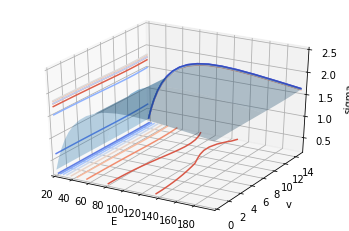

In [32]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X=EMat
Y=vMat
Z=sigma

# Plot the 3D surface
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
cset = ax.contour(X, Y, Z, zdir='z', offset=0.2, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=min(X[0]), cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=max(Y[:,0]), cmap=cm.coolwarm)

ax.set_xlim(min(X[0]),max(X[0]))
ax.set_ylim(min(Y[:,0]),max(Y[:,0]))
ax.set_zlim(0.2,2.5)

ax.set_xlabel('E')
ax.set_ylabel('v')
ax.set_zlabel('sigma')

plt.show()

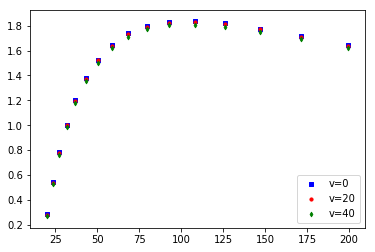

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x=EMat[0]
y=sigma[0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='v=0')
y=sigma[5]
ax1.scatter(x,y, s=10, c='r', marker="o", label='v=20')
y=sigma[10]
ax1.scatter(x,y, s=10, c='g', marker="d", label='v=40')
plt.legend(loc='lower right');
plt.show()

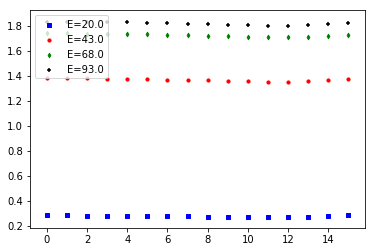

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x=vMat[:,0]
y=sigma[:,0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='E='+str(round(EMat[0,0])))
y=sigma[:,5]
ax1.scatter(x,y, s=10, c='r', marker="o", label='E='+str(round(EMat[0,5])))
y=sigma[:,8]
ax1.scatter(x,y, s=10, c='g', marker="d", label='E='+str(round(EMat[0,8])))
y=sigma[:,10]
ax1.scatter(x,y, s=10, c='black', marker="+", label='E='+str(round(EMat[0,10])))
plt.legend(loc='upper left');
plt.show()

In [35]:
cropDim = [(150, 180, 700, 490)]

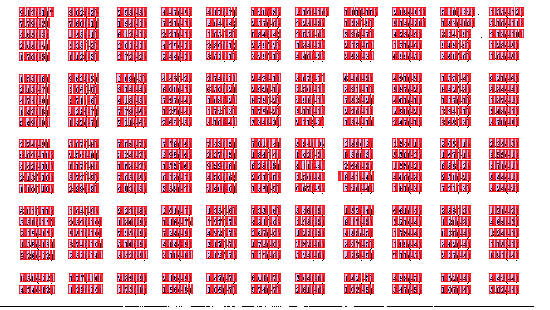

In [36]:
data = scraper.getTableData(pdf=pdfGilmore,pageNumber=92,cropDimArray=cropDim,locateTables=True)